In [1]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal, Annotated
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage
from dotenv import load_dotenv
import operator

load_dotenv()

True

In [2]:
generator_llm = ChatOpenAI(model="gpt-4o-mini")
evaluator_llm = ChatOpenAI(model="gpt-4o-mini")
optimizer_llm = ChatOpenAI(model="gpt-4o-mini")

## Schemas

In [3]:
from pydantic import BaseModel, Field

class TweetEvaluation(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(..., description="Final evaluation result.")
    feedback: str = Field(..., description="Feedback for the tweet.")

In [4]:
structured_evaluator_llm = evaluator_llm.with_structured_output(TweetEvaluation)

## State

In [5]:
class TweetState(TypedDict):

    topic: str
    tweet: str
    evaluation: Literal["approved", "needs_improvement"]
    feedback: str
    iteration: int
    max_iteration: int
    tweet_history: Annotated[list[str], operator.add]
    feedback_history: Annotated[list[str], operator.add]

## Functions

In [6]:
def generate_tweet(state: TweetState):
    # prompt
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(
            content=f"""
            Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

            Rules:
            - Do NOT use question-answer format.
            - Max 280 characters.
            - Use observational humor, irony, sarcasm, or cultural references.
            - Think in meme logic, punchlines, or relatable takes.
            - Use simple, day to day english
            """
        )
    ]

    response = generator_llm.invoke(messages).content
    return {'tweet': response, 'tweet_history': [response]}

In [7]:
def evaluate_tweet(state: TweetState):
    messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(
        content=f"""
            Evaluate the following tweet:

            Tweet: "{state['tweet']}"

            Use the criteria below to evaluate the tweet:

            1. Originality – Is this fresh, or have you seen it a hundred times before?
            2. Humor – Did it genuinely make you smile, laugh, or chuckle?
            3. Punchiness – Is it short, sharp, and scroll-stopping?
            4. Virality Potential – Would people retweet or share it?
            5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

            Auto-reject if:
            - It's written in question-answer format (e.g., "Why did..." or "What happens when...")
            - It exceeds 280 characters
            - It reads like a traditional setup-punchline joke
            - Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

            ### Respond ONLY in structured format:
            - evaluation: "approved" or "needs_improvement"
            - feedback: One paragraph explaining the strengths and weaknesses
            """
        )
    ]

    response = structured_evaluator_llm.invoke(messages)
    return {"evaluation": response.evaluation, "feedback": response.feedback, "feedback_history": [response.feedback]}

In [8]:
def optimize_tweet(state: TweetState):
    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(
            content=f"""
            Improve the tweet based on this feedback:
            "{state['feedback']}"

            Topic: "{state['topic']}"
            Original Tweet:
            {state['tweet']}

            Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
            """
        )
    ]

    response = optimizer_llm.invoke(messages).content
    iteration = state['iteration'] + 1
    return {'tweet': response, 'iteration': iteration, 'tweet_history': [response]}

## Conditional Checker

In [9]:
def route_evaluation(state: TweetState) -> Literal["approved", "needs_improvement"]:
    if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iteration']:
        return "approved"
    else:
        return "needs_improvement"

## Graph

In [10]:
graph = StateGraph(TweetState)

graph.add_node("generate_tweet", generate_tweet)
graph.add_node("evaluate_tweet", evaluate_tweet)
graph.add_node("optimize_tweet", optimize_tweet)

graph.add_edge(START, "generate_tweet")
graph.add_edge("generate_tweet", "evaluate_tweet")

graph.add_conditional_edges("evaluate_tweet", route_evaluation, {"approved": END, "needs_improvement": "optimize_tweet"})
graph.add_edge("optimize_tweet", "evaluate_tweet")

workflow = graph.compile()

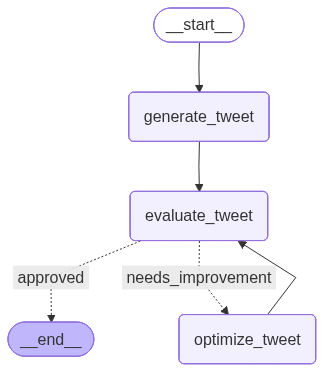

In [12]:
workflow

In [15]:
initial_state = {
    "topic": "Egdbeq",
    "iteration": 1,
    "max_iteration": 5,
}
workflow.invoke(initial_state)

{'topic': 'Egdbeq',
 'tweet': 'Egdbeq: when you face-plant your thoughts into the keyboard and suddenly your keys are Picasso! 🎨 Who knew “deep in thought” could look like modern art? #Egdbeq #AbstractTyping ',
 'evaluation': 'approved',
 'feedback': "This tweet stands out for its originality; it creatively describes the chaotic yet artistic manifestation of thoughts on a keyboard, which is an uncommon metaphor. The humor is subtle yet effective, evoking a chuckle at the absurdity of comparing accidental keyboard smudges to Picasso's art. It is punchy enough, maintaining a concise length while still generating intrigue, which contributes to its virality potential. Additionally, the format is well-structured and adheres to Twitter's character limit, making it an engaging post that could resonate well with others.",
 'iteration': 2,
 'max_iteration': 5,
 'tweet_history': ["Egdbeq: the secret code word for when you accidentally type with your face. It's that moment when you think you’re d